# Data Analysis

### Read the CSV file into a Pandas Dataframe

In [1]:
# Imports
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt

CSV_GRANOS = 'datasets\granos_argentina_1941_2023.csv'

# Read CSV
try:
    df = pd.read_csv(CSV_GRANOS, encoding='latin-1')
except FileNotFoundError:
    print(f"Error: El archivo {CSV_GRANOS} no se encontró.")
    df = pd.DataFrame()  # Empty DataFrame in case of Error

### Agregamos una columna: % Cosechado
Se calcula el porcentaje de cosecha sobre la siembre de cada entrada para agregarlo en una nueva columna antes de exportar a la base de datos.

**Nota**: Si bien se supone que ya no hay nulos en la columna de superficie sembrada debido a la limpieza de datos, se vuelve a chequear nuevamente para no tener divisiones por cero.

In [2]:
import numpy as np 
# Usamos np.where para manejar la división por cero
    # Si la superficie sembrada es 0, asignamos 0.0 al porcentaje cosechado.
    # Si la superficie sembrada > 0, realizamos el cálculo.    

def calcular_porcentaje_cosechado(df):

    # Calculamos el porcentaje
    df['porcentaje_cosechado'] = np.where(
        df['superficie_sembrada_ha'] > 0, 
        (df['superficie_cosechada_ha'] / df['superficie_sembrada_ha']) * 100, 
        0.0  # Asignamos 0.0 si la siembra fue 0
    )

    # Convertir a float con dos decimales para una mejor presentación
    df['porcentaje_cosechado'] = df['porcentaje_cosechado'].round(2)
    
    print("Columna 'porcentaje_cosechado' agregada.")
    print("\nVista previa de la nueva columna:")
    print(df[['superficie_sembrada_ha', 'superficie_cosechada_ha', 'porcentaje_cosechado']].head())
    
    return df

# Aplicar la función a tu DataFrame
df = calcular_porcentaje_cosechado(df)

Columna 'porcentaje_cosechado' agregada.

Vista previa de la nueva columna:
   superficie_sembrada_ha  superficie_cosechada_ha  porcentaje_cosechado
0                   95000                    90000                 94.74
1                   52500                    42000                 80.00
2                   22000                    19800                 90.00
3                    3500                     2600                 74.29
4                   10000                     8000                 80.00


## SQLite Database.

### Define functions to load and run SQL queries

In [3]:
# Function to read SQL
def load_query(file_path: str) -> str:
    try:
        with open(file_path, 'r') as f:
            return f.read()
    except FileNotFoundError:
        print(f"ERROR: Cannot find the query file at path: {file_path}")
        return ""


def run_query(query_file: str, SQLITE_DB: str):
    query = load_query(query_file)
    
    if not query:
        print("Could not load the query. Please check the SQL file name.")  
    else:
        conn = None
        try:
            conn = sqlite3.connect(SQLITE_DB)
            df = pd.read_sql_query(query, conn)

        except sqlite3.OperationalError as e:
            print(f"\nERROR in SQL: {e}")

        finally:
            if conn is not None:
                conn.close()
        return df

### Load to SQLite Database

In [4]:
SQLITE_DB = "Granos_Argentina.db"
DF_TO_DATABASE = df

try:
    conn = sqlite3.connect(SQLITE_DB)
    # Create table "grano_argentina"
    DF_TO_DATABASE.to_sql('granos_argentina', conn, if_exists='replace', index=False)
except sqlite3.Error as e:
    print(f"Error al conectar a la base de datos SQLite: {e}")
finally:
    if conn:
        conn.close()


In [5]:
df_all = run_query('queries/selectAll.sql',SQLITE_DB)
df_all.head()

,cultivo_nombre,anio,campania,provincia_nombre,provincia_id,departamento_nombre,departamento_id,superficie_sembrada_ha,superficie_cosechada_ha,produccion_tm,rendimiento_kgxha,porcentaje_cosechado
0,trigo,1941,1941/1942,Buenos Aires,6.0,Adolfo Alsina,6007.0,95000,90000,89640,996,94.74
1,trigo,1941,1941/1942,Buenos Aires,6.0,Adolfo Gonzales Chaves,6014.0,52500,42000,51000,1214,80.00
2,trigo,1941,1941/1942,Buenos Aires,6.0,Alberti,6021.0,22000,19800,26433,1335,90.00
3,trigo,1941,1941/1942,Buenos Aires,6.0,Ayacucho,6042.0,3500,2600,2493,959,74.29
4,trigo,1941,1941/1942,Buenos Aires,6.0,Azul,6049.0,10000,8000,8000,1000,80.00


### QUERIES

In [6]:
# Producción anualizada, rendimiento promedio y porcentaje promedio cosechado por tipo de grano.
df_produccion_anual = run_query('queries/produccion_anual.sql',SQLITE_DB)

# Produccion por provincia y grano en todos los años
df_produccion_provincia = run_query('queries/produccion_por_provincia.sql',SQLITE_DB)

# Rendimiento promedio anual por tipo de grano
df_rendimiento_promedio_anual = run_query('queries/rendimiento_promedio_anual.sql',SQLITE_DB)

# Superficie sembrada anual
df_superficie_anual = run_query('queries/superficie_sembrada_anual.sql', SQLITE_DB)

## VISUALIZACION

### Produccion Total Anual

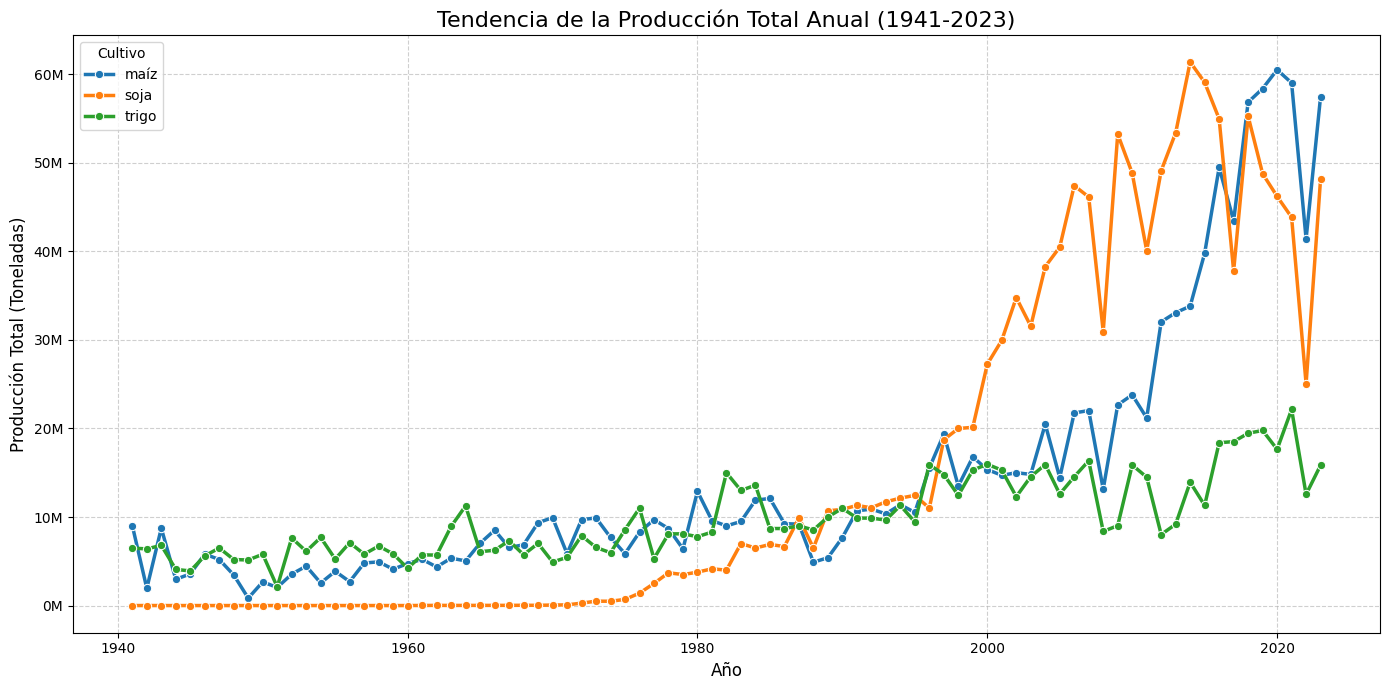

In [7]:
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_produccion_anual, 
    x='anio', 
    y='Produccion_Total_TM', 
    hue='cultivo_nombre', 
    marker='o', 
    errorbar=None,
    linewidth=2.5
)

# Formatear el eje Y para millones de Toneladas (TM)
from matplotlib.ticker import FuncFormatter
def millones_formatter(x, pos):
    """Formatea los valores del eje Y en millones (M)"""
    return f'{x*1e-6:,.0f}M' 

plt.gca().yaxis.set_major_formatter(FuncFormatter(millones_formatter))

plt.title('Tendencia de la Producción Total Anual (1941-2023)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Producción Total (Toneladas)', fontsize=12)
plt.legend(title='Cultivo', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Distribución de Producción Total por Provincia

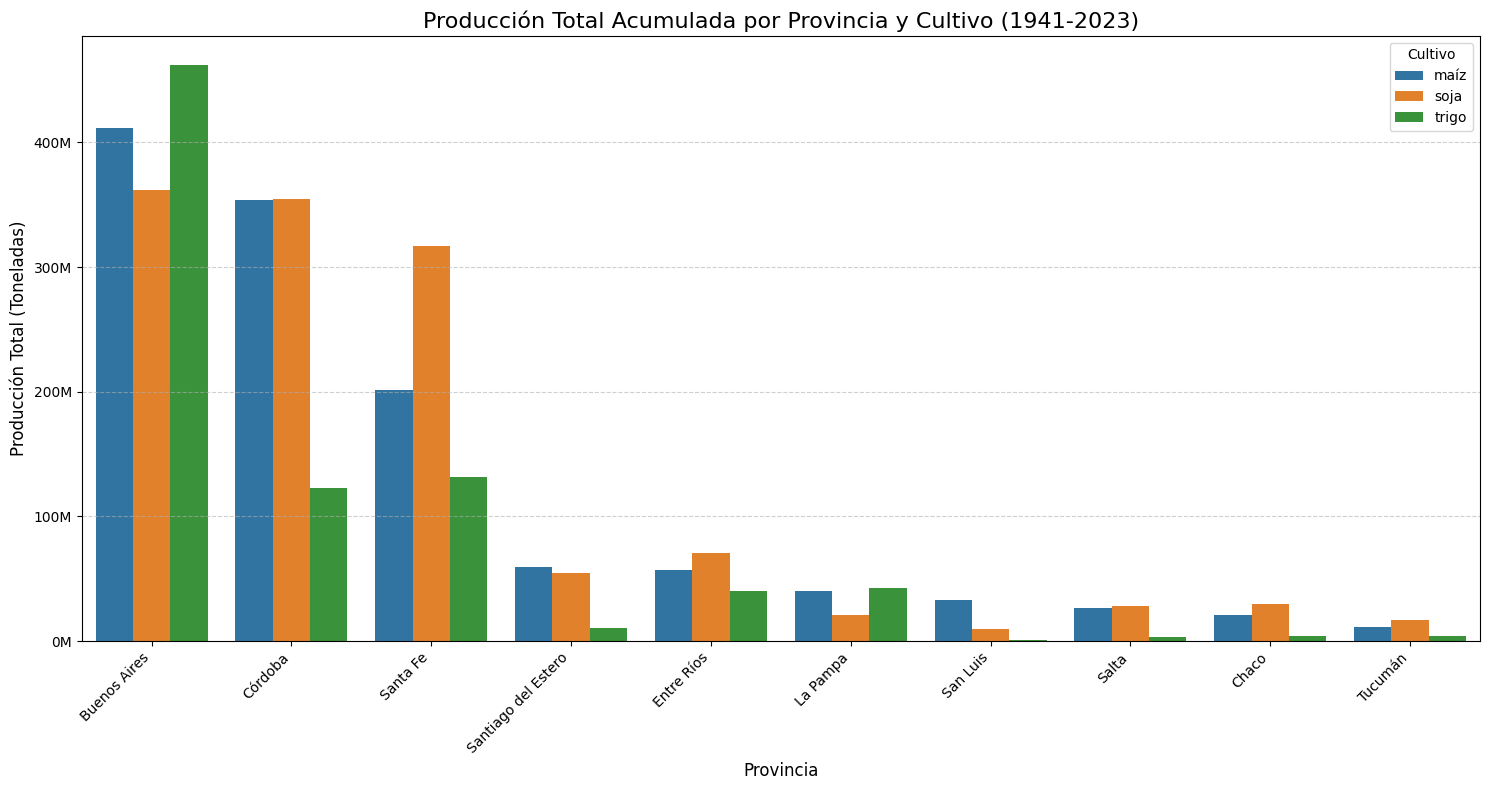

In [8]:
# Gráfica 2: Producción Total por Provincia y Cultivo
# DataFrame: df_produccion_provincia (Produccion_Total_TM)

# Seleccionar las 10 principales provincias en producción total para mayor claridad
df_top_provincias = df_produccion_provincia.groupby('provincia_nombre')['Produccion_Total_TM'].sum().nlargest(10).index
df_provincia_filtrada = df_produccion_provincia[df_produccion_provincia['provincia_nombre'].isin(df_top_provincias)]


plt.figure(figsize=(15, 8))
# Usamos un barplot de seaborn para comparar fácilmente los grupos
sns.barplot(
    data=df_provincia_filtrada,
    x='provincia_nombre',
    y='Produccion_Total_TM',
    hue='cultivo_nombre',
    dodge=True # Barras agrupadas en lugar de apiladas
)

# Formatear el eje Y para millones de Toneladas (TM)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millones_formatter))


plt.title('Producción Total Acumulada por Provincia y Cultivo (1941-2023)', fontsize=16)
plt.xlabel('Provincia', fontsize=12)
plt.ylabel('Producción Total (Toneladas)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotar nombres de provincias
plt.legend(title='Cultivo')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Rendimiento Promedio Anual por Tipo de Grano

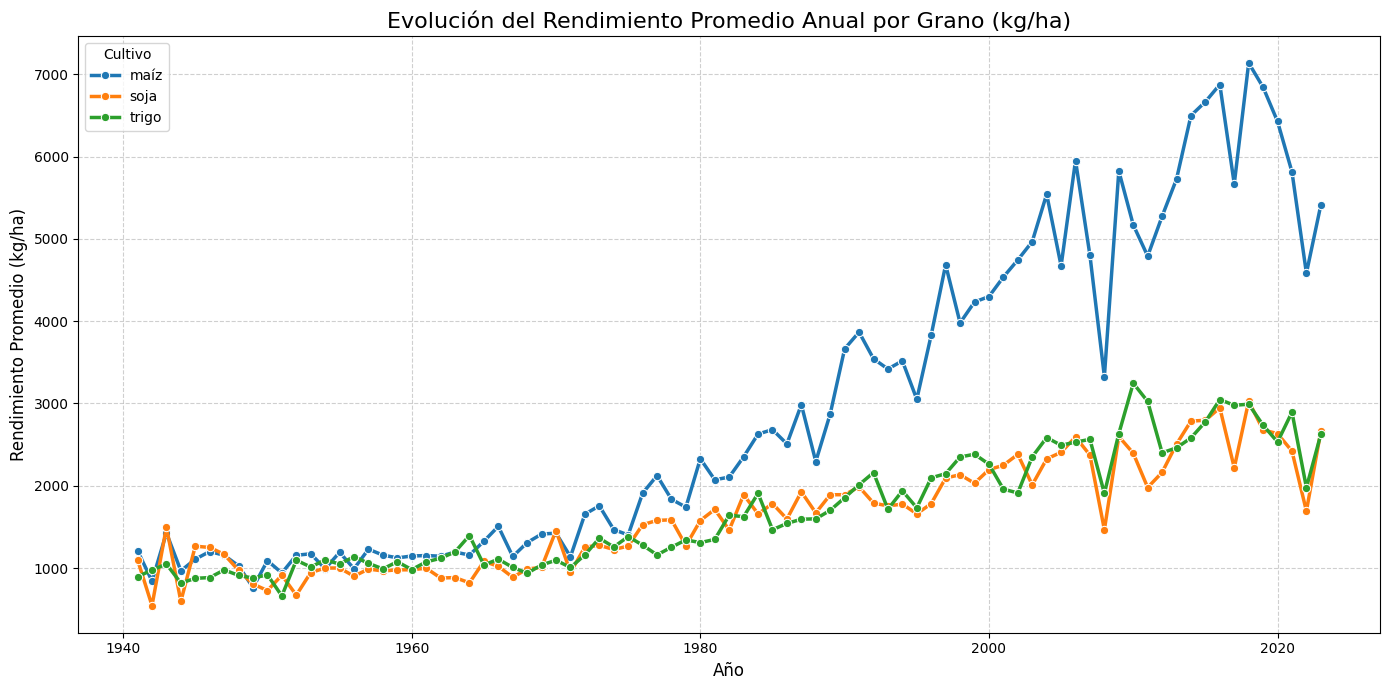

In [9]:
# Gráfica 3: Rendimiento Promedio Anual por Cultivo
# DataFrame: df_rendimiento_promedio_anual (Rendimiento_Promedio_Anual_kgxha)

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_rendimiento_promedio_anual, 
    x='anio', 
    y='rendimiento_prom_anual_kgxha', 
    hue='grano', 
    marker='o', 
    errorbar=None,
    linewidth=2.5
)

plt.title('Evolución del Rendimiento Promedio Anual por Grano (kg/ha)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Rendimiento Promedio (kg/ha)', fontsize=12)
plt.legend(title='Cultivo', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

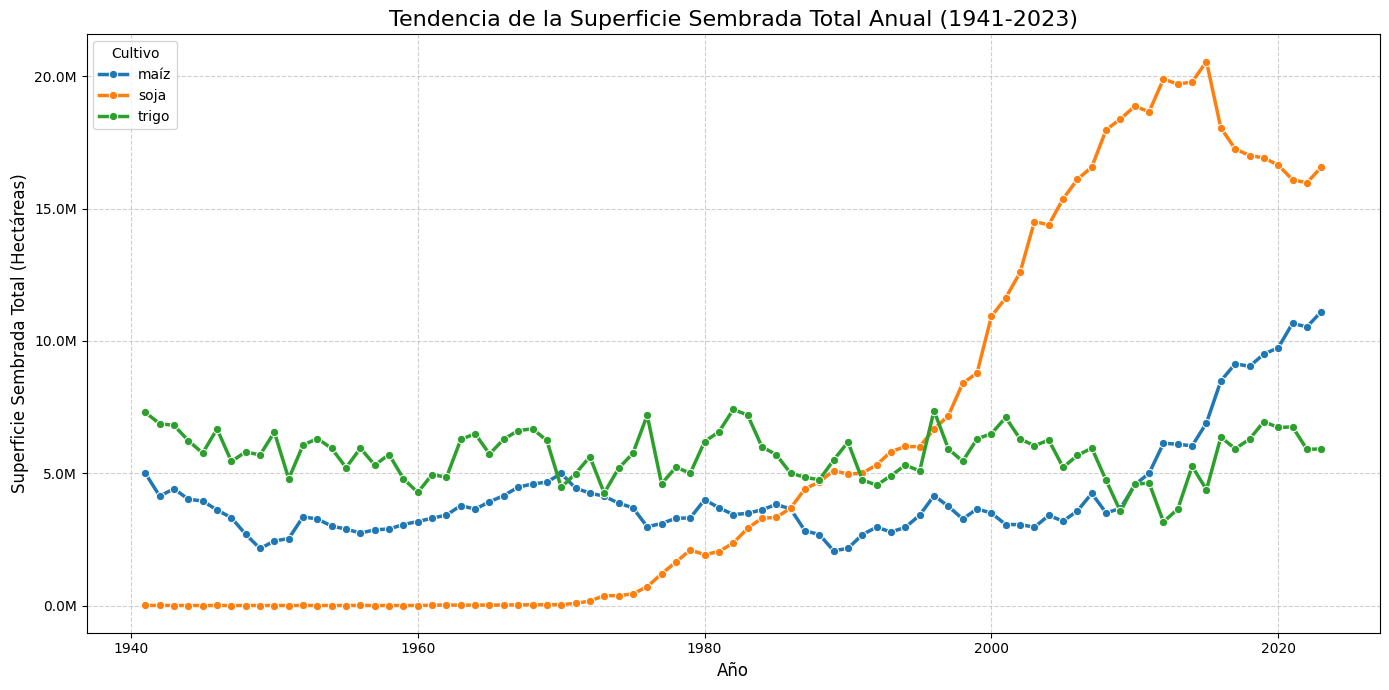

In [10]:
# Gráfica: Superficie Sembrada Total Anual por Cultivo
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_superficie_anual, 
    x='anio', 
    y='Superficie_Sembrada_Total_HA', 
    hue='cultivo_nombre', 
    marker='o', 
    errorbar=None,
    linewidth=2.5
)

# Formatear el eje Y para millones de Hectáreas (HA)
from matplotlib.ticker import FuncFormatter

def millones_ha_formatter(x, pos):
    """Formatea los valores del eje Y en millones (M)"""
    # Dividimos por 1 millón para mostrar en millones de HA
    return f'{x*1e-6:,.1f}M' 

plt.gca().yaxis.set_major_formatter(FuncFormatter(millones_ha_formatter))

plt.title('Tendencia de la Superficie Sembrada Total Anual (1941-2023)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Superficie Sembrada Total (Hectáreas)', fontsize=12)
plt.legend(title='Cultivo', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()